# SpaGCN

# SpaGCN Overview: Inputs, Outputs, and Predictive Capabilities

## 1. Inputs to SpaGCN

**SpaGCN** requires the following main inputs:

### 1.1 Basic Inputs
- **Expression Matrix (AnnData object .X)**  
  - Shape: `(cells/spots, genes/features)`  
  - Typically a log-normalized expression matrix.
- **Spatial Coordinates**  
  - `adata.obs['x_pixel']` and `adata.obs['y_pixel']` (or `x_array`, `y_array`)  
  - Represent the spatial position of each cell or spot.
- **Adjacency Matrix (adj)**  
  - Represents spatial relationships, computed using `spg.calculate_adj_matrix()`.  
  - Depends on spatial coordinates, with optional support for histology images.

### 1.2 Optional Inputs (Histology)
- **Histology Image (TIF/JPG/PNG)**  
  - Optional, to incorporate tissue features into the adjacency matrix.
- **Region Information (ROI/Slide)**  
  - For analyzing multiple tissue sections, `adata.obs['roi']` can distinguish different slides.

---

## 2. Outputs from SpaGCN

### 2.1 Clustering Results
- `adata.obs['pred']`  
  - SpaGCN’s output representing spatial domain (region) clustering results.  
  - Each spot is assigned a cluster label (0, 1, 2, etc.).
- (Optional) `adata.obs['refined_pred']`  
  - Refined domain labels after optional cluster refinement.

### 2.2 Cluster Probabilities
- `prob` (numpy array)  
  - Softmax probabilities for each spot’s cluster membership.

---

## 3. What Can SpaGCN Predict?

SpaGCN is designed to:
- **Predict spatial domains**, such as:
  - Anatomical regions in brain tissue (e.g., cortex, hippocampus)
  - Tumor core and edge regions

SpaGCN is **not** designed to directly predict cell types because:
- It does not use prior marker genes.
- It performs unsupervised clustering based solely on gene expression and spatial relationships.

---

## 4. Is SpaGCN Suitable for Predicting Cell Types?

No, SpaGCN does not directly predict cell types. Its core purpose is to detect potential spatial domains based on adjacency relationships.

If you need cell type predictions, you can:
1. Use Scanpy (e.g., `sc.tl.leiden`, `sc.tl.louvain`) for non-spatial clustering.
2. Annotate clusters with known marker genes to infer cell types.
3. Compare or integrate these results with SpaGCN’s domain output.

---

## 5. Summary

| Feature | SpaGCN |
|---------|--------|
| Inputs | AnnData(X) + (x_pixel, y_pixel) + adj |
| Outputs | `adata.obs['pred']` (domain labels) |
| Directly predicts cell type? | No |
| Supports multiple tissue sections? | Yes |


In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import SpaGCN as spg
import torch
import random
from sklearn.metrics import adjusted_rand_score

# 1. Set random seed
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)


## Load Data

In [6]:
# 2. Load and subsample data
adata = sc.read_h5ad('/home/tingruiz/utag/250331_annotation_xenium_tacco.h5ad')
adata.obs['x'] = adata.obs['x_centroid']
adata.obs['y'] = adata.obs['y_centroid']
adata.obsm['spatial'] = adata.obs[['y', 'x']].to_numpy()

random_indices = np.random.choice(adata.n_obs, size=10000, replace=False)
adata = adata[random_indices].copy()

# 3. Create SpaGCN-compatible metadata
adata.obs['x_array'] = adata.obs['x']
adata.obs['y_array'] = adata.obs['y']
adata.obs['x_pixel'] = adata.obs['x']
adata.obs['y_pixel'] = adata.obs['y']

## Using Model directly

In [7]:
# 4. Calculate adjacency matrix (no histology image)
adj = spg.calculate_adj_matrix(
    x=adata.obs['x_pixel'].tolist(),
    y=adata.obs['y_pixel'].tolist(),
    histology=False
)
np.savetxt('./adj.csv', adj, delimiter=',')

# 5. Preprocess expression data
adata.var_names_make_unique()
spg.prefilter_genes(adata, min_cells=3)
spg.prefilter_specialgenes(adata)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# 6. Search l parameter
p = 0.5
l = spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

# 7. Run SpaGCN with fixed resolution and n_clusters=11
res = 0.2
clf = spg.SpaGCN()
clf.set_l(l)
clf.train(
    adata, adj,
    init_spa=True, init="louvain",
    res=res,
    n_clusters=11,
    tol=5e-3, lr=0.05, max_epochs=200
)
y_pred, prob = clf.predict()
adata.obs['pred'] = pd.Categorical(y_pred)

Calculateing adj matrix using xy only...
Run 1: l [0.01, 1000], p [0.0, 1013.3054]
Run 2: l [0.01, 500.005], p [0.0, 292.4878]
Run 3: l [0.01, 250.0075], p [0.0, 79.3699]
Run 4: l [0.01, 125.00874999999999], p [0.0, 21.087006]
Run 5: l [0.01, 62.509375], p [0.0, 5.576506]
Run 6: l [0.01, 31.2596875], p [0.0, 1.4628468]
Run 7: l [15.63484375, 31.2596875], p [0.36326694, 1.4628468]
Run 8: l [15.63484375, 23.447265625], p [0.36326694, 0.83202755]
Run 9: l [15.63484375, 19.5410546875], p [0.36326694, 0.5771786]
Run 10: l [17.58794921875, 19.5410546875], p [0.46504593, 0.5771786]
Run 11: l [17.58794921875, 18.564501953125003], p [0.46504593, 0.5198281]
recommended l =  18.0762255859375
Initializing cluster centers with louvain, resolution =  0.2


/home/tingruiz/miniconda3/envs/SpaGCN/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch  0
Epoch  10
Epoch  20
delta_label  0.0044 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 28


## Visualization （Ground Truth and result）

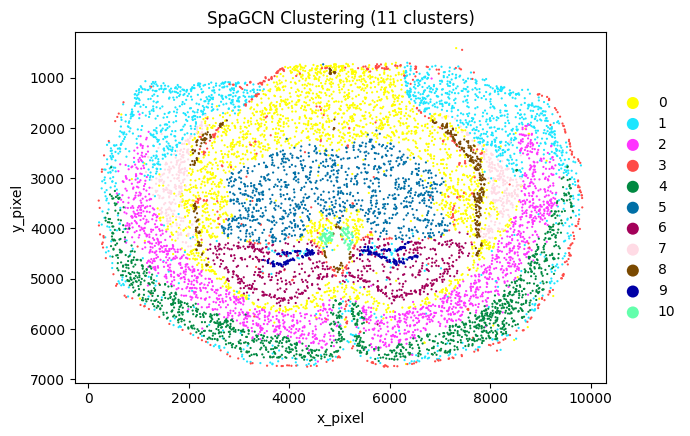

In [9]:
import scanpy as sc

num_clusters = len(adata.obs['pred'].unique())
palette = sc.pl.palettes.default_102  # built-in 102-color palette
adata.uns['pred_colors'] = palette[:num_clusters]

ax = sc.pl.scatter(
    adata,
    alpha=1,
    x='x_pixel',
    y='y_pixel',
    color='pred',
    title='SpaGCN Clustering (11 clusters)',
    show=False,
    size=100000 / adata.shape[0]
)
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig('./SpaGCN_clustering_subsampled_11clusters.png', dpi=300)
plt.show()


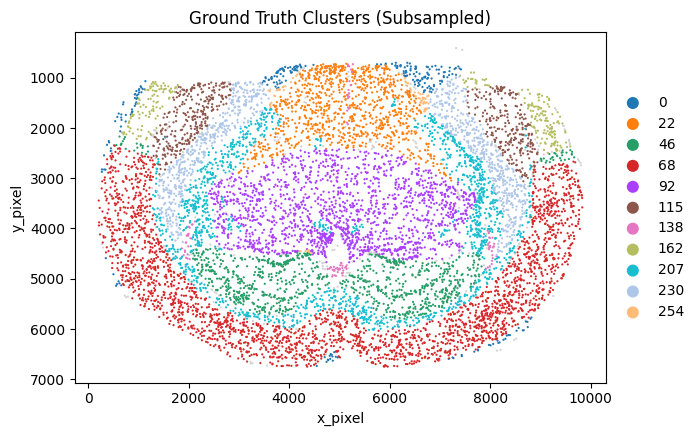

In [10]:
true_labels = adata.obs['cleaned_cluster'].astype(str)
num_true_clusters = len(true_labels.unique())
adata.uns['cleaned_cluster_colors'] = palette[:num_true_clusters]

ax = sc.pl.scatter(
    adata,
    alpha=1,
    x='x_pixel',
    y='y_pixel',
    color='cleaned_cluster',
    title='Ground Truth Clusters (Subsampled)',
    color_map=palette[:num_true_clusters],
    show=False,
    size=100000 / adata.shape[0]
)
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig('./GroundTruth_clustering_subsampled.png', dpi=300)
plt.show()

In [11]:
# 9. Calculate ARI
true_labels = adata.obs['cleaned_cluster'].astype(str).to_numpy()
pred_labels = adata.obs['pred'].astype(str).to_numpy()

valid_mask = ~pd.isna(true_labels)
true_labels_clean = true_labels[valid_mask]
pred_labels_clean = pred_labels[valid_mask]

ari_score = adjusted_rand_score(true_labels_clean, pred_labels_clean)
print(f"\nAdjusted Rand Index (ARI) between SpaGCN clustering and true domains: {ari_score:.4f}")


Adjusted Rand Index (ARI) between SpaGCN clustering and true domains: 0.2709
